In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, accuracy_score

In [5]:
# Define the file path
file_path = '/content/drive/MyDrive/Reviews.csv'

df = pd.read_csv(file_path)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [7]:
df.shape

(568454, 10)

In [8]:
# Drop specified columns
columns_to_drop = ['ProductId', 'Id', 'ProfileName', 'UserId', 'HelpfulnessDenominator', 'HelpfulnessNumerator', 'Time']
df.drop(columns=columns_to_drop, inplace=True)


In [9]:
# Verify the columns are dropped
df.head()

,Score,Summary,Text
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,2,Cough Medicine,If you are looking for the secret ingredient i...
4,5,Great taffy,Great taffy at a great price. There was a wid...


In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [11]:
# Combine 'summary' and 'text' into a single feature, ensuring all text is properly handled
df['Summary'] = df['Summary'].fillna('').astype(str)
df['Text'] = df['Text'].fillna('').astype(str)
df['Combined_text'] = df['Summary'] + " " + df['Text']

In [12]:
# Preprocess the text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['Combined_text'])
sequences = tokenizer.texts_to_sequences(df['Combined_text'])
word_index = tokenizer.word_index

In [13]:
# Pad sequences to ensure uniform input size
max_length = 300
data = pad_sequences(sequences, maxlen=max_length)
data.shape

(568454, 300)

In [14]:
y_dict = {1:0, 2:0, 3:1, 4:1, 5:1}
y = df['Score'].map(y_dict)
y

0         1
1         0
2         1
3         0
4         1
         ..
568449    1
568450    0
568451    1
568452    1
568453    1
Name: Score, Length: 568454, dtype: int64

In [15]:
ros = RandomOverSampler(random_state=42)
data_resampled, labels_resampled = ros.fit_resample(data, y)

label_counts = Counter(labels_resampled)
print(label_counts)

Counter({1: 486417, 0: 486417})


In [16]:
from tensorflow.keras.utils import to_categorical
# Encode labels (after oversampling)
label_encoder = LabelEncoder()
labels_resampled = label_encoder.fit_transform(labels_resampled)
labels_resampled = to_categorical(labels_resampled, num_classes=2)

In [17]:
# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(data_resampled, labels_resampled, test_size=0.2, random_state=42)

In [18]:
print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

x_train shape: (778267, 300)
x_val shape: (194567, 300)
y_train shape: (778267, 2)
y_val shape: (194567, 2)


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
# Define the model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_length))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

In [20]:
model.compile(optimizer='adam', loss ='binary_crossentropy', metrics=['accuracy'])

In [21]:
# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 128)          1280000   
                                                                 
 lstm (LSTM)                 (None, 300, 128)          131584    
                                                                 
 dropout (Dropout)           (None, 300, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 1461122 (5.57 MB)
Trainable params: 146112

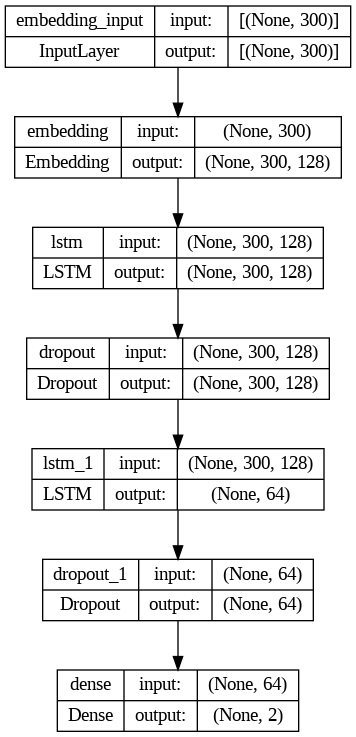

In [22]:
from tensorflow.keras.utils import plot_model

# Assuming your model is already created and named `model`

plot_model(model, to_file="Architecture of Amazon LSTM  2 scores.png", show_shapes=True)  # Adjust filename as needed

In [ ]:
import time
# Start time measurement
start_time = time.time()

# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_val, y_val))

# End time measurement
end_time = time.time()

# Calculate total time
total_time = end_time - start_time
print(f"Total training time: {total_time:.4f} seconds")

Epoch 1/5
24321/24321 [==============================] - 655s 27ms/step - loss: 0.1829 - accuracy: 0.9314 - val_loss: 0.1224 - val_accuracy: 0.9568
Epoch 2/5
24321/24321 [==============================] - 604s 25ms/step - loss: 0.0952 - accuracy: 0.9680 - val_loss: 0.0884 - val_accuracy: 0.9713
Epoch 3/5
24321/24321 [==============================] - 630s 26ms/step - loss: 0.0626 - accuracy: 0.9803 - val_loss: 0.0769 - val_accuracy: 0.9767
Epoch 4/5
24321/24321 [==============================] - 632s 26ms/step - loss: 0.0448 - accuracy: 0.9864 - val_loss: 0.0645 - val_accuracy: 0.9813
Epoch 5/5
24321/24321 [==============================] - 628s 26ms/step - loss: 0.0341 - accuracy: 0.9899 - val_loss: 0.0604 - val_accuracy: 0.9834
Total training time: 3150.0762 seconds


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(x_val, y_val)
print(f'Validation Accuracy: {accuracy}')

6081/6081 [==============================] - 60s 10ms/step - loss: 0.0604 - accuracy: 0.9834
Validation Accuracy: 0.9833579063415527


In [ ]:
# Example prediction
new_texts = ["This product is excellent.", "Not what I expected."]
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_data = pad_sequences(new_sequences, maxlen=max_length)

predictions = model.predict(new_data)
predicted_labels = label_encoder.inverse_transform(predictions.argmax(axis=1))
print(predicted_labels)

1/1 [==============================] - 2s 2s/step
[1 0]


In [ ]:
# Predict on the validation set
y_val_pred = model.predict(x_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(y_val, axis=1)

6081/6081 [==============================] - 57s 9ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
# Calculate metrics
accuracy = accuracy_score(y_val_true, y_val_pred_classes)
precision = precision_score(y_val_true, y_val_pred_classes, average='weighted')
recall = recall_score(y_val_true, y_val_pred_classes, average='weighted')
f1 = f1_score(y_val_true, y_val_pred_classes, average='weighted')
conf_matrix = confusion_matrix(y_val_true, y_val_pred_classes)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

print("\nClassification Report:\n", classification_report(y_val_true, y_val_pred_classes))



Accuracy: 0.9833579178380712
Precision: 0.9835031658285178
Recall: 0.9833579178380712
F1 Score: 0.9833566807085765

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     97275
           1       0.99      0.97      0.98     97292

    accuracy                           0.98    194567
   macro avg       0.98      0.98      0.98    194567
weighted avg       0.98      0.98      0.98    194567



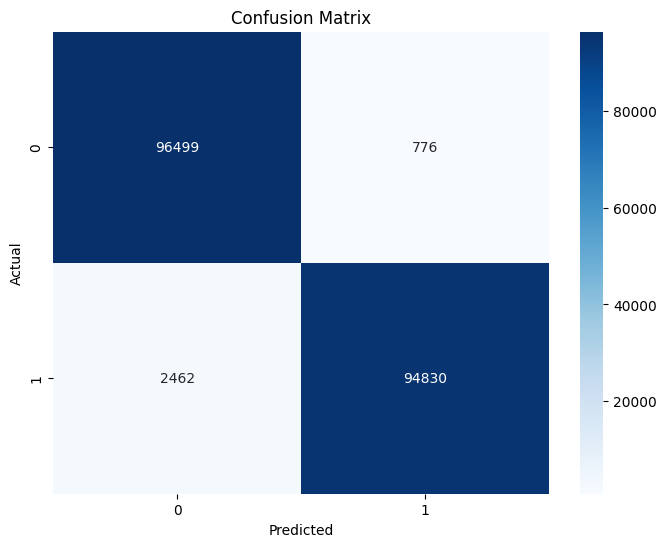

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()